In [1]:
# COLMAP
%cd /notebooks
!pip install -q plyfile pycolmap Pillow==9.5.0 pycolmap plotly

!sudo apt-get update
!sudo apt-get install libglm-dev

!pip install -q /notebooks/diff-gaussian-rasterization
!pip install -q /notebooks/gaussian-splatting/submodules/simple-knn

!apt install imagemagick -y
# remove line 88 of vim ~/../etc/ImageMagick-6/policy.xml to run MoviePy
!sed -i '88d' ~/../etc/ImageMagick-6/policy.xml 

!sudo apt-get update && sudo apt-get install -y \
	ninja-build \
	libeigen3-dev \
	libflann-dev \
	libsqlite3-dev \
	libgl1-mesa-dev \
	cmake \
	libgoogle-glog-dev \
	libgflags-dev \
	libsuitesparse-dev \
	libceres-dev \
	libcgal-dev \
	libcgal-qt5-dev \
	libmetis-dev \
	libfreeimage-dev \
	libglew-dev

!sudo updatedb   # update the database used by locate
!locate Eigen3Config.cmake
!locate libflann

# # # Build COLMAP
# !git clone https://github.com/colmap/colmap.git
# %cd /notebooks/colmap
# !rm -rf build
# !mkdir build
# %cd /notebooks/colmap/build
# !cmake .. -DCMAKE_CUDA_ARCHITECTURES=native -GNinja

%cd /notebooks/colmap/build
!ninja
!sudo ninja install

# Check if colmap is installed
!colmap -h

%cd /notebooks


#HLOC
!pip install mediapy

# !rm -rf /notebooks/Hierarchical-Localization
# !git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/

%cd /notebooks/Hierarchical-Localization
!pip install --progress-bar off --quiet -e .


%cd /notebooks

/notebooks
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://deb.nodesource.com/node_16.x focal InRelease [4583 B]            
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB] 
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1188 kB]
Get:9 https://deb.nodesource.com/node_16.x focal/main amd64 Packages [776 B]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1421 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3597 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/mult

In [2]:
# !rm -rf /notebooks/output
# !mkdir /notebooks/output

In [3]:
%cd /notebooks/Hierarchical-Localization
from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_retrieval, colmap_from_nvm, pairs_from_exhaustive, pairs_from_covisibility
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

import sys
sys.path.append('/notebooks/Hierarchical-Localization/third_party') 
sys.path.append('/notebooks/Hierarchical-Localization/third_party/d2net')
sys.path.append('/notebooks/Hierarchical-Localization/third_party/deep-image-retrieval')
sys.path.append('/notebooks/Hierarchical-Localization/third_party/r2d2')
sys.path.append('/notebooks/Hierarchical-Localization/third_party/SuperGluePretrainedNetwork')
%cd /notebooks


%cd /notebooks
import glob
import os
import sys
import shutil
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
from pathlib import Path
from time import time
import torch
import pycolmap

/notebooks/Hierarchical-Localization
/notebooks
/notebooks


/notebooks


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e


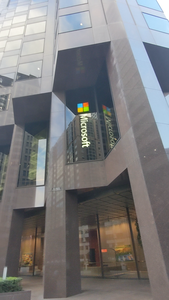
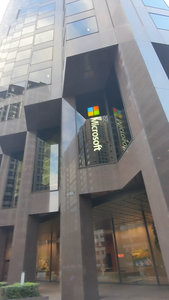
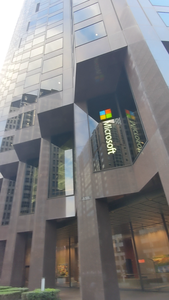
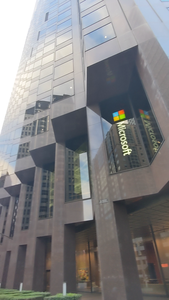
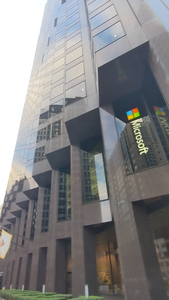
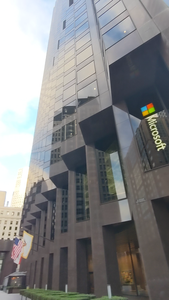
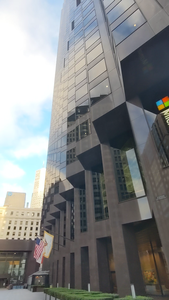
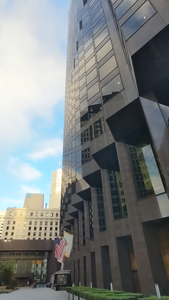
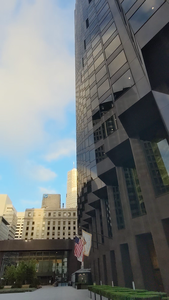
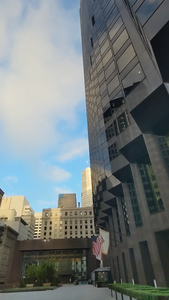
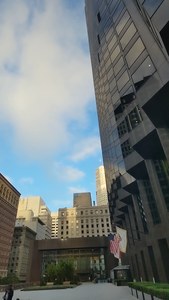
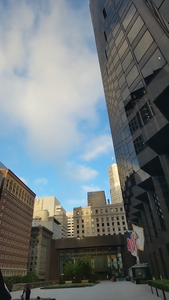
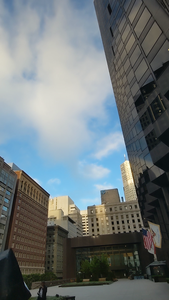
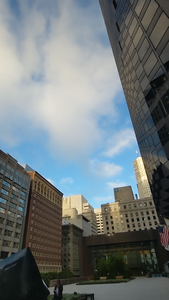
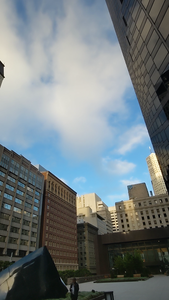
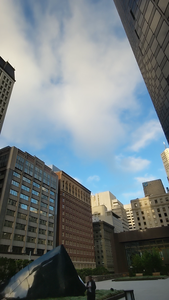

CPU times: user 1.26 s, sys: 298 ms, total: 1.55 s
Wall time: 6.88 s


In [10]:
%%time
%cd /notebooks

# Prepare the input images
!rm -rf /notebooks/working
!mkdir /notebooks/working
!mkdir /notebooks/working/input

init_videos = glob.glob("/notebooks/data/*.mp4")
init_videos.sort()
init_video = init_videos[-2]
# init_video = "/notebooks/data/IMG_7205.MOV"

# !ffmpeg -i {init_video} -ss 00:00:00 -t 00:00:5 -vf fps=5 /notebooks/working/input/%05d.png
!ffmpeg -i {init_video} -vf fps=3 /notebooks/working/input/%05d.png

print("\n\n")
print("Number of images:", len(glob.glob("/notebooks/working/input/*.png")))

images = sorted(glob.glob('/notebooks/working/input/*.png'))
print(len(images))

show_images = [cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB) for im in images[:16]]
media.show_images(show_images, height=300, columns=4)

In [11]:
%%time
%cd /notebooks

location = Path('/notebooks/working')
images = location / 'input'
image_list = [path.split(str(images.stem) + "/")[-1] for path in sorted(glob.glob(str(images / '*')))]
outputs = location / 'sfm'
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_max']
matcher_conf = match_features.confs['superglue']

extract_features.main(feature_conf, images, image_list=image_list, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=image_list)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=image_list)

fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

[2023/10/15 08:17:39 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


/notebooks
Loaded SuperPoint model


100%|██████████| 25/25 [00:01<00:00, 17.49it/s]
[2023/10/15 08:17:40 hloc INFO] Finished exporting features.
[2023/10/15 08:17:40 hloc INFO] Found 300 pairs.
[2023/10/15 08:17:40 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 300/300 [00:39<00:00,  7.60it/s]
[2023/10/15 08:18:21 hloc INFO] Finished exporting matches.
[2023/10/15 08:18:21 hloc INFO] Creating an empty database...
[2023/10/15 08:18:21 hloc INFO] Importing images into the database...
[2023/10/15 08:18:23 hloc INFO] Importing features into the database...
100%|██████████| 25/25 [00:00<00:00, 684.50it/s]
[2023/10/15 08:18:23 hloc INFO] Importing matches into the database...
100%|██████████| 300/300 [00:00<00:00, 771.54it/s]
[2023/10/15 08:18:23 hloc INFO] Performing geometric verification of the matches...
[2023/10/15 08:18:25 hloc INFO] Running 3D reconstruction...
W1015 08:19:40.861619 12832 levenberg_marquardt_strategy.cc:123] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W1015 08:19:40.890033 12832 levenberg_marquardt_strategy.cc:123] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W1015 08:19:40.8

CPU times: user 11min 16s, sys: 1min 7s, total: 12min 23s
Wall time: 4min 27s


In [12]:
%cd /notebooks

!rm -rf /notebooks/working_output

!colmap image_undistorter \
	--image_path /notebooks/working/input \
	--input_path {sfm_dir} \
	--output_path /notebooks/working_output \
	--output_type COLMAP \
	# --max_image_size 2000

!mv /notebooks/working_output/sparse/ /notebooks/working_output/sparse_tmp/
!mkdir /notebooks/working_output/sparse/
!mv /notebooks/working_output/sparse_tmp/ /notebooks/working_output/sparse/0/

/notebooks

Reading reconstruction

 => Reconstruction with 25 images and 8269 points

Image undistortion

Undistorting image [1/25]
Undistorting image [2/25]
Undistorting image [3/25]
Undistorting image [4/25]
Undistorting image [5/25]
Undistorting image [6/25]
Undistorting image [7/25]
Undistorting image [8/25]
Undistorting image [9/25]
Undistorting image [10/25]
Undistorting image [11/25]
Undistorting image [12/25]
Undistorting image [13/25]
Undistorting image [14/25]
Undistorting image [15/25]
Undistorting image [16/25]
Undistorting image [17/25]
Undistorting image [18/25]
Undistorting image [19/25]
Undistorting image [20/25]
Undistorting image [21/25]
Undistorting image [22/25]
Undistorting image [23/25]
Undistorting image [24/25]
Undistorting image [25/25]
Writing reconstruction...
Writing configuration...
Writing scripts...
Elapsed time: 0.067 [minutes]


In [13]:
%cd /notebooks
!python /notebooks/gaussian-splatting/train.py -s /notebooks/working_output -r 2

/notebooks


Optimizing 
Output folder: ./output/2747ebc7-9 [15/10 08:22:36]
Reading camera 25/25 [15/10 08:22:38]
Converting point3d.bin to .ply, will happen only the first time you open the scene. [15/10 08:22:38]
Loading Training Cameras [15/10 08:22:38]
Loading Test Cameras [15/10 08:22:43]
Number of points at initialisation :  8269 [15/10 08:22:43]
Training progress:  23%|▋  | 7000/30000 [01:55<08:05, 47.39it/s, Loss=0.0158506]
[ITER 7000] Evaluating train: L1 0.011157992295920849 PSNR 35.03376388549805 [15/10 08:24:40]

[ITER 7000] Saving Gaussians [15/10 08:24:40]
Training progress:  58%|█▏| 17530/30000 [06:06<04:50, 42.90it/s, Loss=0.0108623]